# Museum Attendance vs City Population

This notebook explores the relationship between museum annual visitors and city population using the ingested datasets and trained regression model.

Sections:
1. Load Data & Environment
2. Quick Data Audit
3. Scatter (log–log) + Regression Line
4. Residual Analysis
5. Top Residuals (Over/Under Performance)
6. Model Artifact Inspection
7. Notes & Next Improvements


In [1]:
# 1. Load Data & Environment (clean cwd-based path handling)
import json, math, os, statistics, textwrap, sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Root resolution strategy -----------------------------------------------------
# Start from current working directory; if this isn't project root (no pyproject.toml),
# walk up until we find one. Fallback to cwd if not found.
root = Path.cwd().resolve()
probe = root
while not (probe / 'pyproject.toml').exists() and probe.parent != probe:
    probe = probe.parent
if (probe / 'pyproject.toml').exists():
    root = probe

print(f"Detected project root: {root}")

if str(root) not in sys.path:
    sys.path.insert(0, str(root))

# Clear cached project modules so edits are picked up in notebooks
for name in list(sys.modules):
    if name.startswith('src.'):
        sys.modules.pop(name)

from src.etl import run_pipeline
from src.model import build_features_frame, train_and_persist, load_model_artifact

DATA_DIR = root / 'data'
MODEL_PATH = root / 'models' / 'visitors_population_linreg.json'

print(f"MODEL_PATH    => {MODEL_PATH}")

# Ensure SQLite database exists
if not (DATA_DIR / 'museums.sqlite').exists():
    print("SQLite DB missing; running ETL pipeline...")
    run_pipeline(save_raw=True)

features = build_features_frame()
if features.empty:
    raise RuntimeError("No feature rows available—verify ETL results.")

print('Built features shape:', features.shape)
print(features.head())

if not MODEL_PATH.exists():
    print("Model artifact missing; training via model module ...")
    metrics = train_and_persist()
    print('Training complete. Metrics:', metrics)

try:
    model_artifact = load_model_artifact()
    print('Model loaded. Metrics:', model_artifact.get('training_metrics'))
except FileNotFoundError as exc:
    model_artifact = None
    print('Model artifact still not available; downstream sections will be skipped.', exc)


Detected project root: /Users/pierre/Developer/ivado
MODEL_PATH    => /Users/pierre/Developer/ivado/models/visitors_population_linreg.json
Built features shape: (29, 8)
                          museum_name country      city   visitors  \
0                              Louvre  France     Paris  8737050.0   
1  Shanghai Museum East (opened 2024)   China  Shanghai  4234046.0   
2                       Musée d'Orsay  France     Paris  3751141.0   
3                     Museo del Prado   Spain    Madrid  3457057.0   
4                     Pompidou Center  France     Paris  3204369.0   

   population  log_visitors  log_population  visitors_per_1000  
0   2206488.0     15.983083       14.606913        3959.708822  
1  23019196.0     15.258669       16.951839         183.935442  
2   2206488.0     15.137571       14.606913        1700.050487  
3   3277451.0     15.055928       15.002577        1054.800514  
4   2206488.0     14.980026       14.606913        1452.248551  
Model loaded. Metric

In [2]:
# 1. Load Data & Environment (clean cwd-based path handling)
import json, math, os, statistics, textwrap, sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Root resolution strategy -----------------------------------------------------
# Start from current working directory; if this isn't project root (no pyproject.toml),
# walk up until we find one. Fallback to cwd if not found.
root = Path.cwd().resolve()
probe = root
while not (probe / 'pyproject.toml').exists() and probe.parent != probe:
    probe = probe.parent
if (probe / 'pyproject.toml').exists():
    root = probe

print(f"Detected project root: {root}")

if str(root) not in sys.path:
    sys.path.insert(0, str(root))

from src.etl import run_pipeline
from src.model import build_features_frame, train_and_persist, load_model_artifact

DATA_DIR = root / 'data'
MODEL_PATH = root / 'models' / 'visitors_population_linreg.json'

print(f"MODEL_PATH    => {MODEL_PATH}")

# Ensure SQLite database exists
if not (DATA_DIR / 'museums.sqlite').exists():
    print("SQLite DB missing; running ETL pipeline...")
    run_pipeline(save_raw=True)

features = build_features_frame()
if features.empty:
    raise RuntimeError("No feature rows available—verify ETL results.")

print('Built features shape:', features.shape)
print(features.head())

if not MODEL_PATH.exists():
    print("Model artifact missing; training via model module ...")
    metrics = train_and_persist()
    print('Training complete. Metrics:', metrics)

try:
    model_artifact = load_model_artifact()
    print('Model loaded. Metrics:', model_artifact.get('training_metrics'))
except FileNotFoundError as exc:
    model_artifact = None
    print('Model artifact still not available; downstream sections will be skipped.', exc)


Detected project root: /Users/pierre/Developer/ivado
MODEL_PATH    => /Users/pierre/Developer/ivado/models/visitors_population_linreg.json
Built features shape: (29, 8)
                          museum_name country      city   visitors  \
0                              Louvre  France     Paris  8737050.0   
1  Shanghai Museum East (opened 2024)   China  Shanghai  4234046.0   
2                       Musée d'Orsay  France     Paris  3751141.0   
3                     Museo del Prado   Spain    Madrid  3457057.0   
4                     Pompidou Center  France     Paris  3204369.0   

   population  log_visitors  log_population  visitors_per_1000  
0   2206488.0     15.983083       14.606913        3959.708822  
1  23019196.0     15.258669       16.951839         183.935442  
2   2206488.0     15.137571       14.606913        1700.050487  
3   3277451.0     15.055928       15.002577        1054.800514  
4   2206488.0     14.980026       14.606913        1452.248551  
Model loaded. Metric

In [3]:
# 2. Quick Data Audit

# Basic numeric summaries
numeric_cols = ['visitors','population']
summary = features[numeric_cols].describe().T
summary['missing'] = [features[c].isna().sum() for c in numeric_cols]
summary

,count,mean,std,min,25%,50%,75%,max,missing
visitors,29.0,2.051128e+06,1.593264e+06,833699.0,1128140.0,1459371.0,2369339.0,8737050.0,0
population,29.0,3.350942e+06,4.691852e+06,159993.0,790279.0,2206488.0,3277451.0,23019196.0,0


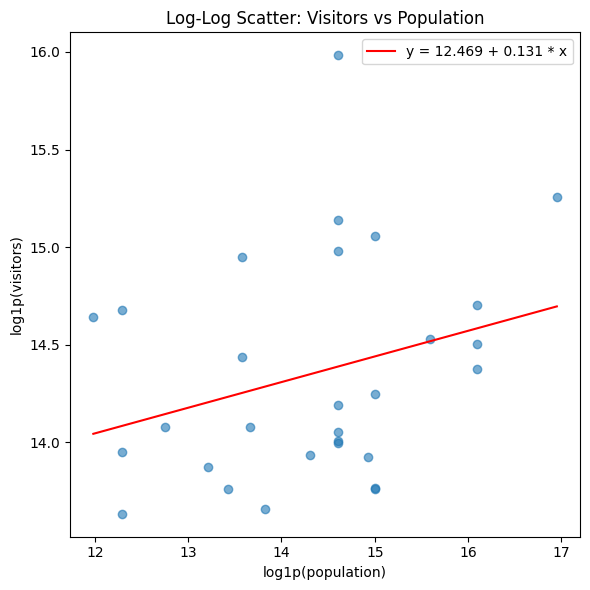

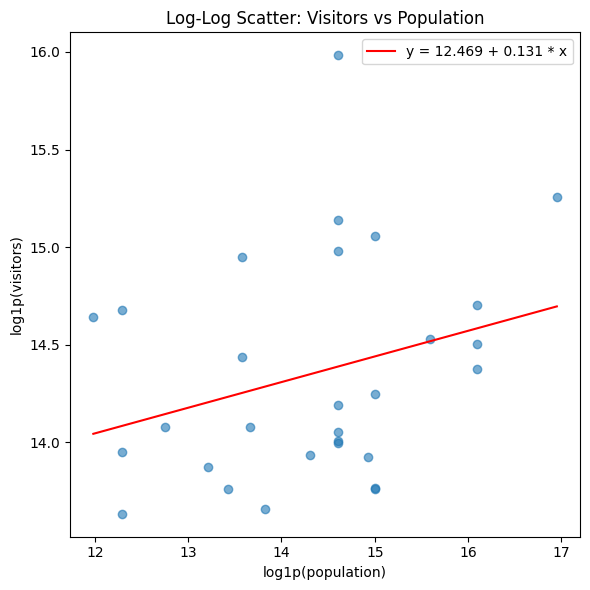

In [4]:
# 3. Scatter (log-log) + Regression Line

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(features['log_population'], features['log_visitors'], alpha=0.6)
ax.set_xlabel('log1p(population)')
ax.set_ylabel('log1p(visitors)')
ax.set_title('Log-Log Scatter: Visitors vs Population')

# If model artifact exists, overlay regression line
if model_artifact:
    coef = model_artifact['model']['coef_log'][0]
    intercept = model_artifact['model']['intercept_log']
    xs = np.linspace(features['log_population'].min(), features['log_population'].max(), 100)
    ys = intercept + coef * xs
    ax.plot(xs, ys, color='red', label=f'y = {intercept:.3f} + {coef:.3f} * x')
    ax.legend()
plt.tight_layout()
fig

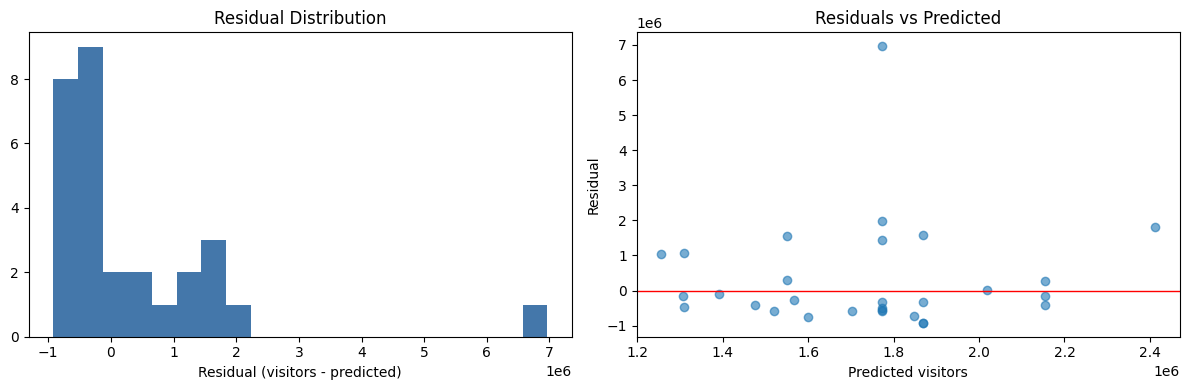

In [5]:
# 4. Residual Analysis
import pandas as _pd

if model_artifact:
    coef = model_artifact['model']['coef_log'][0]
    intercept = model_artifact['model']['intercept_log']
    preds_log = intercept + coef * features['log_population']
    preds = np.expm1(preds_log)
    resid = features['visitors'] - preds
    features['_prediction'] = preds
    features['_residual'] = resid

    fig2, ax2 = plt.subplots(1,2, figsize=(12,4))
    ax2[0].hist(resid, bins=20, color='#4477aa')
    ax2[0].set_title('Residual Distribution')
    ax2[0].set_xlabel('Residual (visitors - predicted)')

    ax2[1].scatter(preds, resid, alpha=0.6)
    ax2[1].axhline(0, color='red', lw=1)
    ax2[1].set_xlabel('Predicted visitors')
    ax2[1].set_ylabel('Residual')
    ax2[1].set_title('Residuals vs Predicted')
    plt.tight_layout()
    fig2
else:
    print('Model artifact not available; skipping residual analysis.')

In [6]:
# 5. Top Residuals (Absolute)
if model_artifact and '_residual' in features.columns:
    top_abs = features.assign(abs_res=lambda d: d['_residual'].abs()) \
        .sort_values('abs_res', ascending=False) \
        .head(10)[['museum_name','country','city','visitors','_prediction','_residual','abs_res']]
    top_abs
else:
    print('Residuals not computed.')

In [7]:
# 6. Model Artifact Inspection
if model_artifact:
    display(model_artifact['training_metrics'])
    print('Coefficient (log space):', model_artifact['model']['coef_log'])
    print('Intercept (log space):', model_artifact['model']['intercept_log'])
else:
    print('No model artifact to inspect.')

{'r2': 0.010812040118068467,
 'mae': 922691.748222674,
 'rmse': 1557066.4682606703,
 'n_rows': 29.0}

Coefficient (log space): [0.13136752599833545]
Intercept (log space): 12.469334082004593


### 7. Notes & Next Improvements

- Add city name canonicalization to raise join coverage.
- Investigate leverage points (largest residuals) for potential data issues.
- Consider multivariate model once new features (e.g., tourism index, GDP per capita) are sourced.
- Validate stability: retrain with random museum holdout and compare coefficient variance.
- Potentially switch to robust regression (Huber) if heavy-tailed residuals persist.
